### Implementing Binary Relevance multilabel classifier

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.6 MB/s 


In [1]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random

In [67]:
## Reading cleaned data
data = pd.read_csv('data/Matcatdf_MN_training.csv')
data.head()

,REVISION,MODEL,AC_HRS,AC_LANDINGS,F6M,L12M,MATCAT_CLASS,avionics,structure,consumables,...,lights,windows,aes,"wheel, tire, brakes",powerplant,hydraulics,ecs,interior,landing gear,prop
0,43.0,525C,273.0,151.0,12.0,15.0,"['consumables', 'avionics', 'hardware', 'struc...",1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,68.0,560XL,3954.1,3195.0,16.0,0.0,"['consumables', 'flight controls', 'hardware']",0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,88.0,680A,810.2,607.0,0.0,10.0,"['consumables', 'hardware']",0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,108.0,680,2550.2,1630.0,1.0,31.0,"['hardware', 'actuators', 'structure', 'fuel']",0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,113.0,750,526.0,513.0,10.0,260.0,"['structure', 'batteries', 'equipment', 'consu...",0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [68]:
data.shape

(46766, 26)

In [69]:
data1 = data[['AC_HRS','AC_LANDINGS','F6M','L12M','MATCAT_CLASS']]
data1.head()

,AC_HRS,AC_LANDINGS,F6M,L12M,MATCAT_CLASS
0,273.0,151.0,12.0,15.0,"['consumables', 'avionics', 'hardware', 'struc..."
1,3954.1,3195.0,16.0,0.0,"['consumables', 'flight controls', 'hardware']"
2,810.2,607.0,0.0,10.0,"['consumables', 'hardware']"
3,2550.2,1630.0,1.0,31.0,"['hardware', 'actuators', 'structure', 'fuel']"
4,526.0,513.0,10.0,260.0,"['structure', 'batteries', 'equipment', 'consu..."


In [75]:
data1.to_csv('data/sample.csv')

In [4]:
#-----------target labels: different service categories to be predicted 

labels = ['avionics', 'structure', 'consumables','hardware','flight controls',
          'actuators','fuel','batteries','equipment','lights','windows','aes',
          'wheel tire brakes','powerplant', 'hydraulics','ecs','interior',
          'landing gear','prop']

In [5]:
# ------------- Aircraft models included for modeling

model_names = ['560', '510', '525C', '525A', '680A','525',
          '525B', '750', 'FL', '680', '560XL','Other']


In [6]:
#----------converting the model names into dummy columns

model_col = data[['MODEL']]
df_model = pd.get_dummies(model_col)
df_model.shape


(46766, 12)

#### Creating Input and Target dataset

In [7]:
#instantiating the X

X = data[['AC_HRS','AC_LANDINGS','F6M','L12M']]
X = pd.concat([df_model, X], axis = 1)
X.head()

,MODEL_510,MODEL_525,MODEL_525A,MODEL_525B,MODEL_525C,MODEL_560,MODEL_560XL,MODEL_680,MODEL_680A,MODEL_750,MODEL_FL,MODEL_OTHER,AC_HRS,AC_LANDINGS,F6M,L12M
0,0,0,0,0,1,0,0,0,0,0,0,0,273.0,151.0,12.0,15.0
1,0,0,0,0,0,0,1,0,0,0,0,0,3954.1,3195.0,16.0,0.0
2,0,0,0,0,0,0,0,0,1,0,0,0,810.2,607.0,0.0,10.0
3,0,0,0,0,0,0,0,1,0,0,0,0,2550.2,1630.0,1.0,31.0
4,0,0,0,0,0,0,0,0,0,1,0,0,526.0,513.0,10.0,260.0


In [8]:
#instantiating the y 

y = data.iloc[:, 7:]
col_names = y.columns
y.head()

,avionics,structure,consumables,hardware,flight controls,actuators,fuel,batteries,equipment,lights,windows,aes,"wheel, tire, brakes",powerplant,hydraulics,ecs,interior,landing gear,prop
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0


In [9]:
y.shape

(46766, 19)

### Functions 

In [38]:
#returns the list of predicted service categories

import itertools 
def get_label(pred,truth):
  pred_cat =[]
  for (i ,j) in itertools.zip_longest(pred[0], truth):  
    if i.astype(int) == 1:
      pred_cat.append(j)
  return pred_cat

In [39]:
# function to find accuracy of each observation

def get_multilabel_accuracy(y_test, y_pred):
    acc=[]
    acc = [ accuracy_score(y_test[ind], y_pred[ind]) for ind in range(y_test.shape[0]) ]
    return np.array(acc)

In [54]:
#select the input model

def select_model(model_n):
  bool_list = np.zeros(len(model_names))
  if model_n in model_names: 
    pos = model_names.index(model_n)
    bool_list[pos] = 1
  return bool_list

In [55]:
# function to input new unseen data to predict 
# one or more service for the aircraft

min_max_scaler = MinMaxScaler()
def sample_data( model_n, flight_hrs, no_landings, f6m, l12m):
  X_sample = np.zeros(16)[np.newaxis, :]
  pos = model_names.index(model_n)
  X_sample[0][pos] = 1
  X_sample[0][12] = flight_hrs
  X_sample[0][13] = no_landings
  X_sample[0][14] = f6m
  X_sample[0][15] = l12m
  X_sample =np.array(min_max_scaler.fit_transform(X_sample.reshape(16,-1)))
  return X_sample.reshape( -1, 16)

In [46]:
# function to test the sample data
def sample_test(data):
  y_sample = c_classifier.predict(X_sample).toarray()
  return get_label(y_sample,labels)


### Preprocessing function

In [16]:
#converting dataset into numpy array
min_max_scaler = MinMaxScaler()
def scaler(x,y): 
  ydata = np.array(y)
  Xdata = np.array(X)
  Xdata = min_max_scaler.fit_transform(Xdata)
  return Xdata, ydata


### Splitting and training

In [17]:
Xdata, ydata = scaler(X,y)
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.20, random_state=42)

In [18]:
X_train[:1]

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.19626325, 0.16523305, 0.07577497,
        0.10032362]])

### 1. Binary Relevance Model

In [19]:
#training the model 
model = BinaryRelevance(GaussianNB())
#model = BinaryRelevance(MultinomialNB())

#train
model.fit(X_train, y_train)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [20]:
#predicting with test dataset

predictions = model.predict(X_test)
y_pred = predictions.toarray()

#### Accuracy Score

In [21]:
#list of accuracy scores
naiveAcc = get_multilabel_accuracy(y_test, y_pred)

#plt.plot(naiveAcc)

#getting the mean accuracy of the model
np.mean(naiveAcc)

0.7441004692616724

#### Probability estimation for each test observation

In [22]:
probabilities = model.predict_proba(X_test).toarray()

#### visual evaluation of the model

In [23]:
df_prob = pd.DataFrame(probabilities, columns = col_names)
df_predlabel = pd.DataFrame(y_pred, columns = col_names)
gt_prob = pd.DataFrame(y_test, columns = col_names)

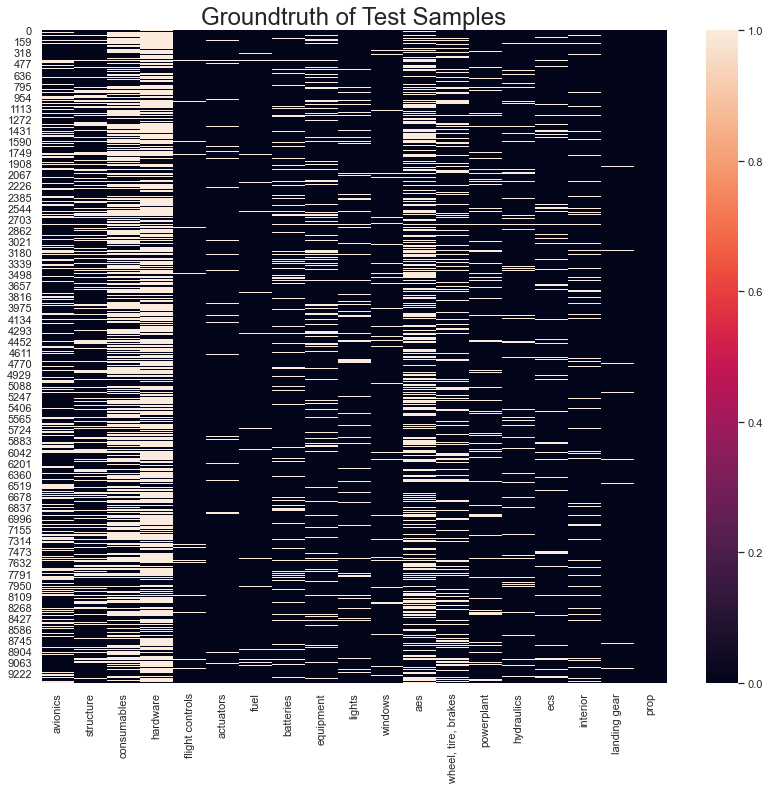

In [25]:
#heatmap of the predicted probability of the y_test

sns.heatmap(gt_prob, xticklabels=col_names)
sns.set(rc={'figure.figsize':(14,12)})
sns_plot = plt.title("Groundtruth of Test Samples", fontsize=24)

plt.show()

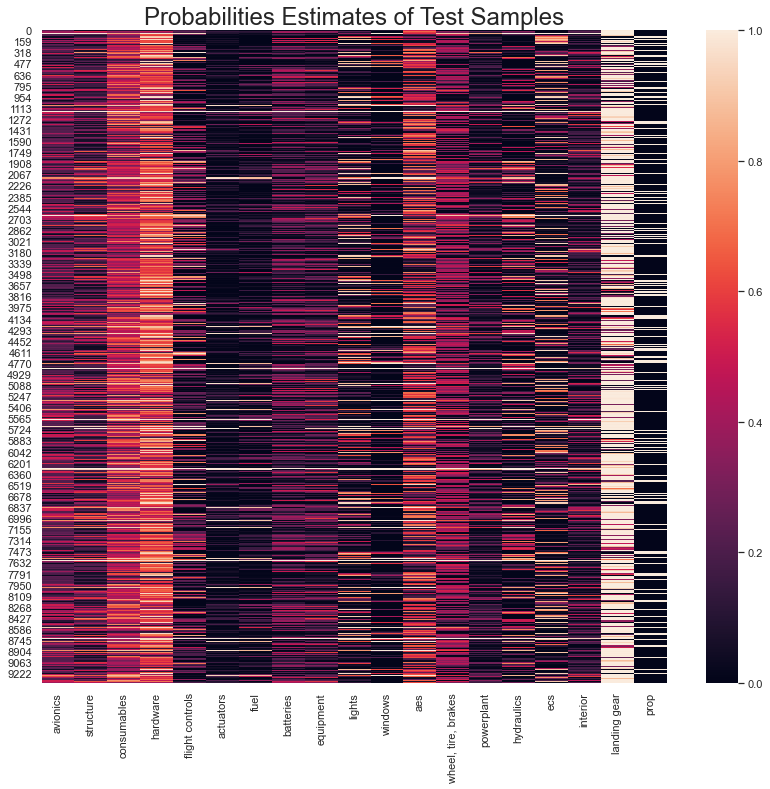

In [26]:
sns.heatmap(df_prob, xticklabels=col_names)

sns.set(rc={'figure.figsize':(16,12)})
sns_plot = plt.title("Probabilities Estimates of Test Samples", fontsize=24)

plt.show()


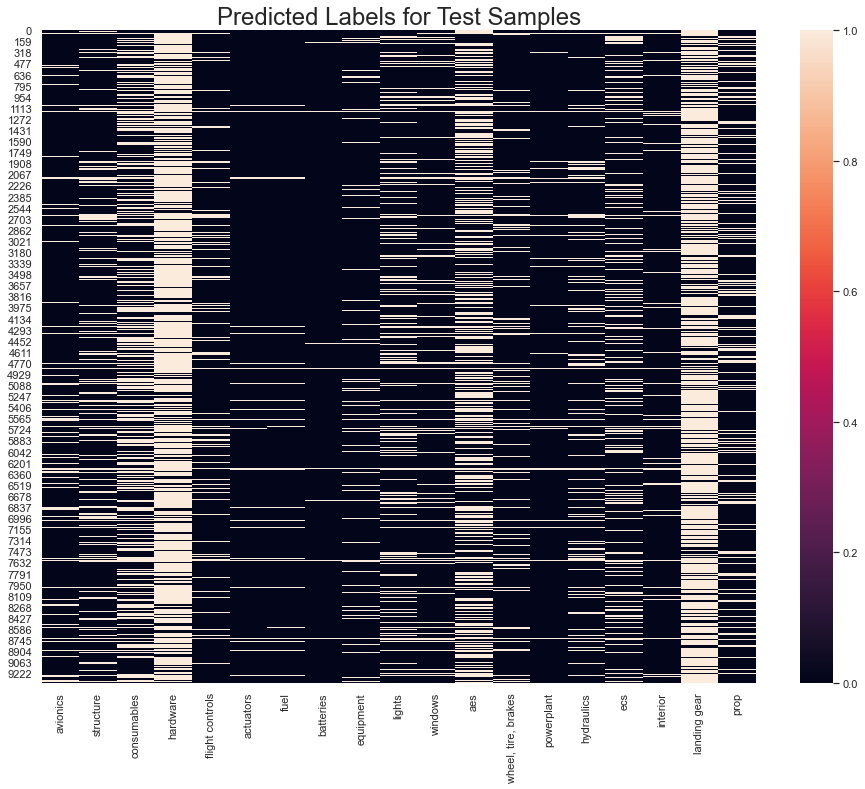

In [27]:
#predicted labels of the y_test

sns.heatmap(df_predlabel, xticklabels=col_names)
sns.set(rc={'figure.figsize':(14,12)})
sns_plot = plt.title("Predicted Labels for Test Samples", fontsize=24)
plt.show()

### Label Powerset

In [ ]:
# train
pwrset_classifier = LabelPowerset(SVC())
pwrset_classifier.fit(X_train, y_train)


LabelPowerset(classifier=SVC(), require_dense=[True, True])

In [ ]:
# save the model to disk
import pickle
filename = 'labpw_model.sav'
pickle.dump(pwrset_classifier, open('labelpowerset_model', 'wb'))

In [ ]:

# predict
prediction = pwrset_classifier.predict(X_test)
y_pred2 = prediction.toarray()


In [178]:
y_pred2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [179]:
#Model accuracy

accuracy2 = get_multilabel_accuracy(y_test, y_pred2)
np.mean(accuracy2)

0.8407042301070187

In [225]:
X_sample = sample_data('FL', 1000, 500, 1000, 900)

# predicting services 
y_label = pwrset_classifier.predict(X_sample).toarray()
get_label(y_label,labels)

['hardware']

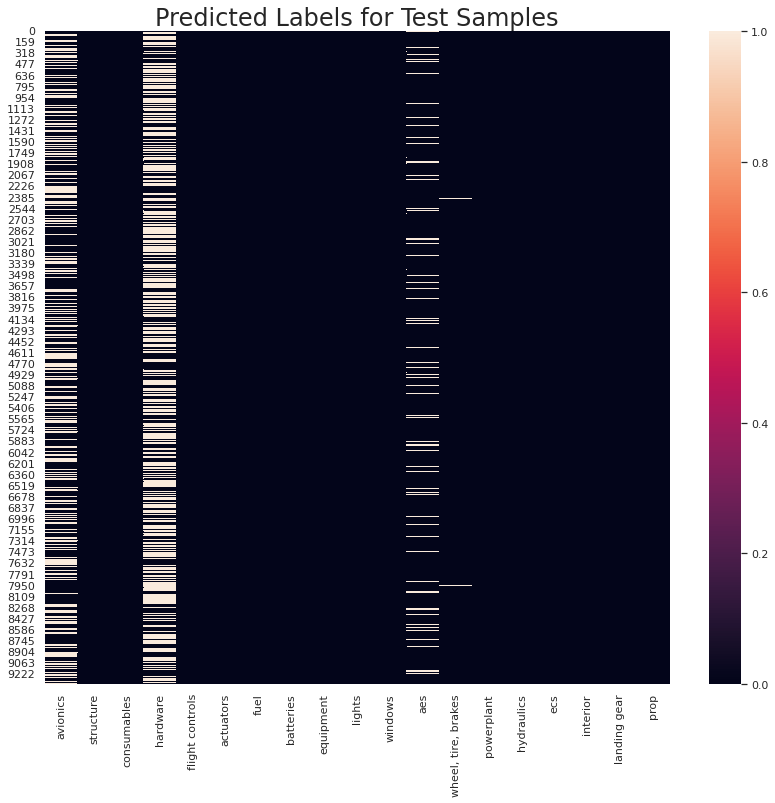

In [234]:
#df_prob = pd.DataFrame(probabilities, columns = col_names)
#gt_prob = pd.DataFrame(y_test, columns = col_names)
df_predlabel_lp = pd.DataFrame(y_pred2, columns = col_names)
sns.heatmap(df_predlabel_lp, xticklabels=col_names)
sns.set(rc={'figure.figsize':(14,12)})
sns_plot = plt.title("Predicted Labels for Test Samples", fontsize=24)
plt.show()

### Chain Classifier

In [31]:
# using Label classifierchain
c_classifier = ClassifierChain(
        RandomForestClassifier(n_estimators = 150,criterion = 'gini'),
        require_dense = [True,True]
          )  #n_estimators = 200,             

# train
c_classifier.fit(X_train, y_train)

ClassifierChain(classifier=RandomForestClassifier(n_estimators=150),
                require_dense=[True, True])

In [32]:
# # predict
prediction = c_classifier.predict(X_test)
y_pred3 = prediction.toarray()

In [33]:
#Model accuracy

accuracy3 = get_multilabel_accuracy(y_test, y_pred3)
np.mean(accuracy3)

0.8136907374272756

In [34]:
#estimated probabilities of each class label 

probabilitiesChain = c_classifier.predict_proba(X_test)
cc_probabilities = probabilitiesChain.toarray()

### Testing with new unseen sample input data

In [64]:
#sample aircraft info 'model, number of flight hours, number of landings, 
# number of services in the first 6 months, number of service visits in last 12 months.

X_sample = sample_data('525C', 1200, 900, 6, 20)
#predicting the services 
sample_test(X_sample)

['consumables', 'hardware']

In [65]:
# sample aircraft info 'model, number of flight hours, number of landings, 
# number of services in the first 6 months, number of service visits in last 12 months.

X_sample = sample_data('FL', 600, 700, 10, 90)

# predicting services 
sample_test(X_sample)


['hardware']

#### visual evaluation of the result

In [ ]:
#converting into dataframe

cc_prob = pd.DataFrame(cc_probabilities, columns = col_names)
cc_predlabel = pd.DataFrame(y_pred3, columns = col_names)
cc_groundtruth = pd.DataFrame(y_test, columns = col_names)

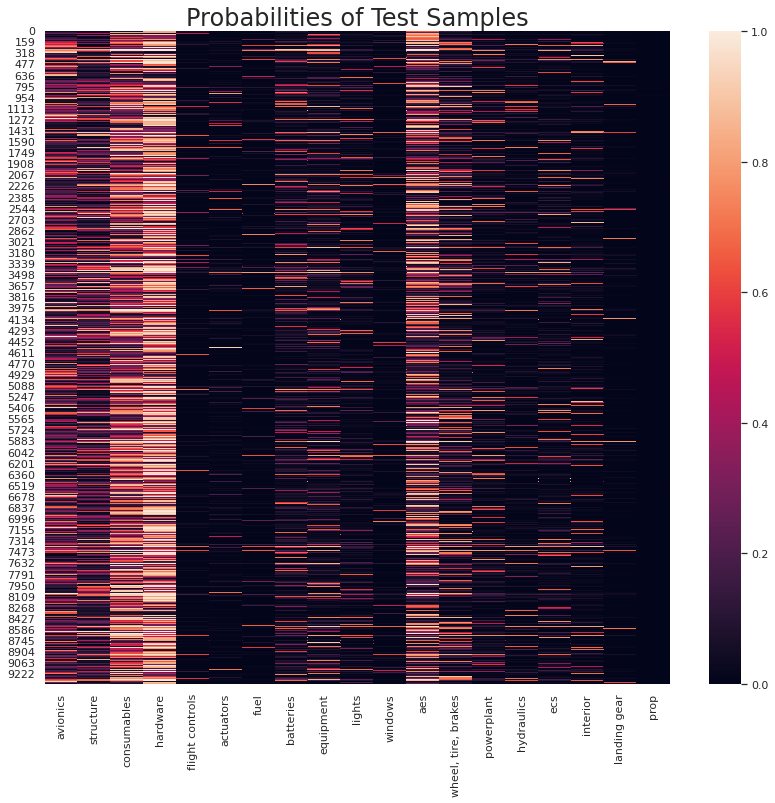

In [ ]:
sns.heatmap(cc_prob, xticklabels=col_names)
sns.set(rc={'figure.figsize':(14,12)})
sns_plot = plt.title("Probabilities of Test Samples", fontsize=24)

plt.show()

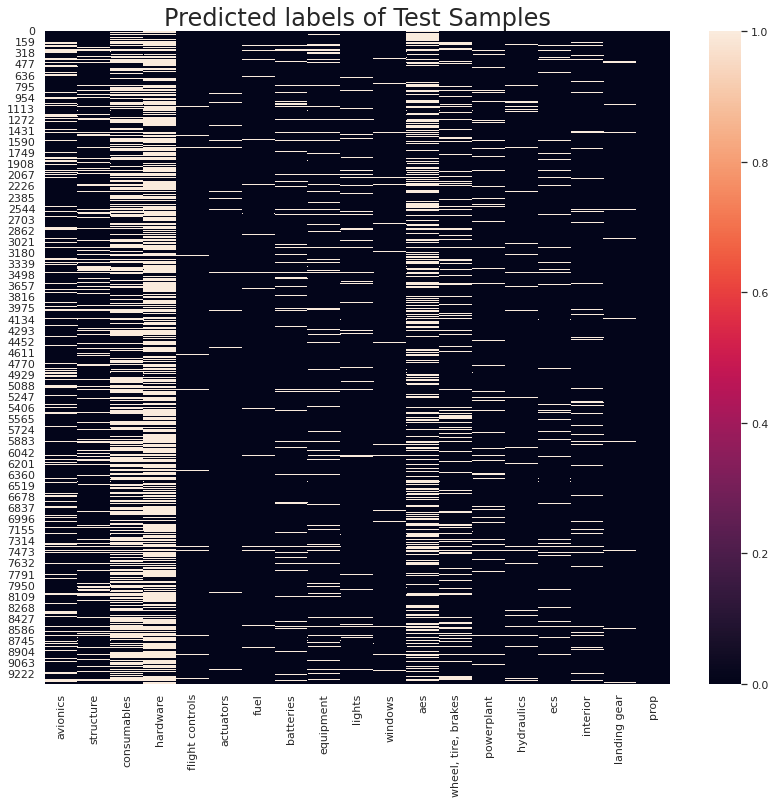

In [ ]:
sns.heatmap(cc_predlabel, xticklabels=col_names)
sns.set(rc={'figure.figsize':(14,12)})
sns_plot = plt.title("Predicted labels of Test Samples", fontsize=24)

plt.show()

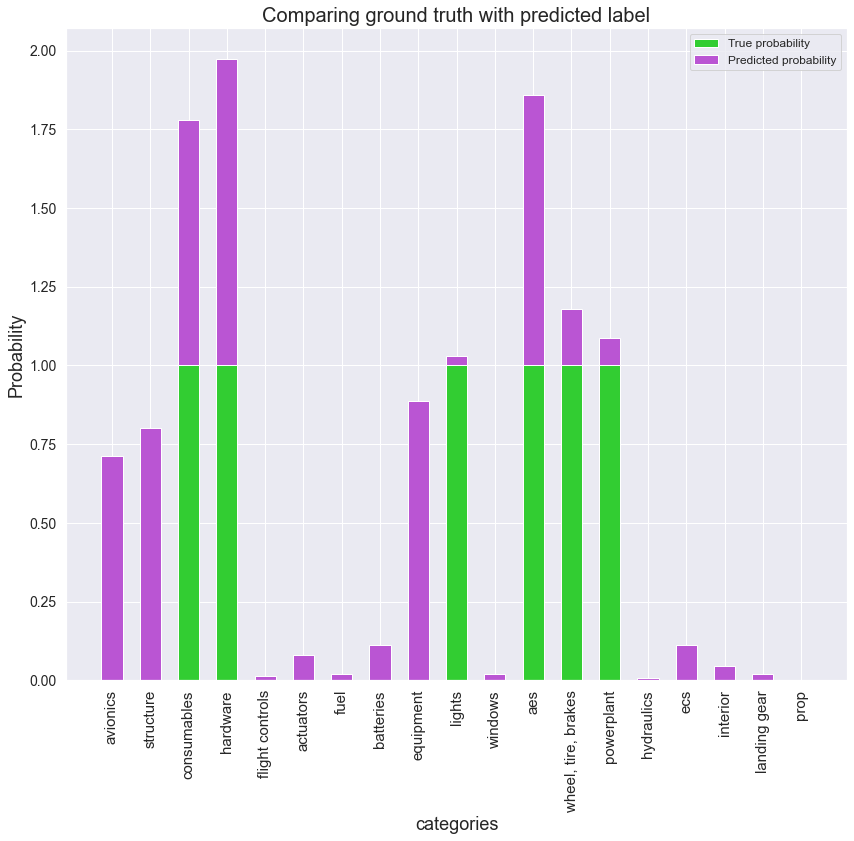

In [73]:
#plotting groundtruth against predicted estimate probability of each category in a single data

width = 0.55       # the width of the bars: can also be len(x) sequence
ind = random.sample(range(0, len(y_test)), 1)[0]

grndtrth = y_test[ind,:]
prob = cc_probabilities[ind,:]

plt.bar(col_names, grndtrth, width, label='True probability', color="limegreen")
plt.bar(col_names, prob, width,bottom = grndtrth, label='Predicted probability',color="mediumorchid")

plt.xlabel('categories',fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=14)
plt.ylabel('Probability',fontsize=18)
plt.title('Comparing ground truth with predicted label',fontsize=20)
plt.legend(fontsize=12)

plt.show()

### hyper-parameter tuning of the selected model with ClassifierChain

hyperparameter tuning doesn't help much but computationally really heavy for my PC it took a whole 5 hours with no significant parameter selection difference. 

In [ ]:
# parameters = [
#      { 'classifier': [SVC()],
#        'classifier__kernel': ['rbf', 'linear'],
#      },
    
#     { 'classifier': [RandomForestClassifier()],
#      'classifier__n_estimators': [100, 150, 200, ],
#      'classifier__criterion': ['gini','entropy']
        
#     }
# ]

In [ ]:
#clf = GridSearchCV(ClassifierChain(), parameters, cv =5, scoring='f1_samples')

In [ ]:
# cv_model = clf.fit(X_train, y_train)
# print(cv_model.best_params_, clf.best_score_)

{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=200), 'classifier__criterion': 'entropy', 'classifier__n_estimators': 200} 0.319464079199579


In [ ]:
# y_pred_cc = cv_model.predict(X_test).toarray()
# y_cc_prob = cv_model.predict_proba(X_test).toarray()

In [ ]:
#ac_cc = get_multilabel_accuracy(y_test, y_pred_cc)

In [74]:
ind 

4567